$d_{1}=0.27 \Rightarrow 0100$

$d_{2}=0.45 \Rightarrow 0111$

$d_{3}=0.76 \Rightarrow 1100$

$d_{4}=0.83 \Rightarrow 1101$

$\varphi_{1}=\frac{2}{\pi} \cos ^{-1} d_{1}=0.8260 \Rightarrow 1101$

$\varphi_{2}=\frac{2}{\pi} \cos ^{-1} d_{2}=0.7028 \Rightarrow 1011$

$\varphi_{3}=\frac{2}{\pi} \cos ^{-1} d_{3}=0.4504 \Rightarrow 0111$

$\varphi_{4}=\frac{2}{\pi} \cos ^{-1} d_{4}=0.3767 \Rightarrow 0110$

In [1]:
# 导入相应的运算库
import numpy as np
from math import pi
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer

In [2]:
# 定义相应的量子寄存器，并添加至电路当中去
# q0寄存器表示地址寄存器
q0 = QuantumRegister(2,'q0')
c0 = ClassicalRegister(2,'c0')
# q1寄存器表示数据寄存器，寄存器的位数表示计算的精度，这里设置为3，最后误差在0.125以内
q1 = QuantumRegister(4,'q1')
c1 = ClassicalRegister(4,'c1')
# q2寄存器表示执行量子算数的的目标寄存器，位数一般与q1寄存器相同
q2 = QuantumRegister(4,'q2')
c2 = ClassicalRegister(4,'c2')
# q3寄存器用来做辅助量子比特，执行系列的受控旋转操作
q3 = QuantumRegister(1,'q3')
c3 = ClassicalRegister(1,'c3')
# 定义一个量子电路对象
Circuit = QuantumCircuit()
# 往寄存器中添加4个量子寄存器
Circuit.add_register(q0,c0)
Circuit.add_register(q1,c1)
Circuit.add_register(q2,c2)
Circuit.add_register(q3,c3)

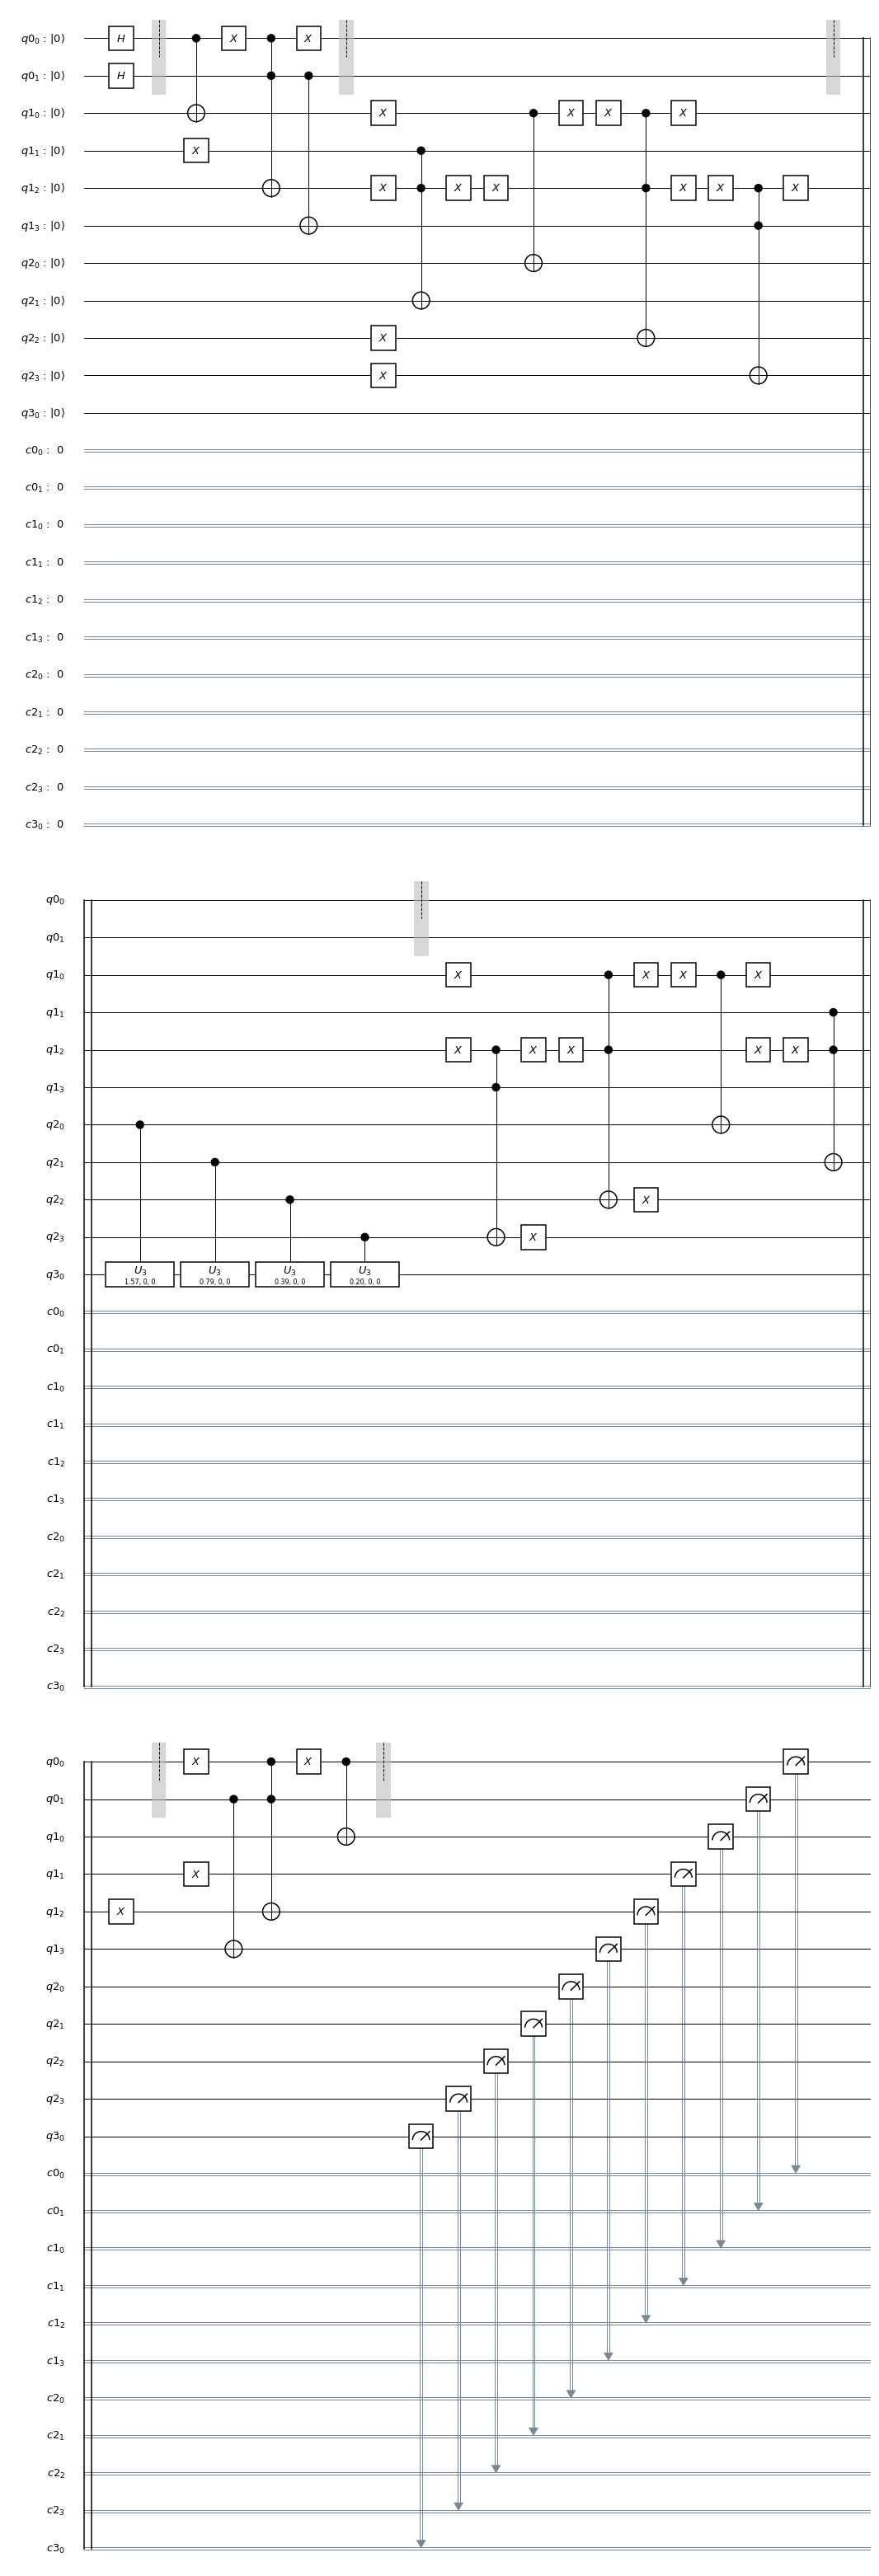

In [3]:
# 添加量子门操作，注意这里的命名方式为最低有效位
# 执行H门操作，将地址寄存器q0张开，分叉存储，由于两个数据只需要用1个量子比特进行表示
Circuit.h(q0[0])
Circuit.h(q0[1])
# 写入数据至q1寄存器，更为通用的采用的是QRAM算法，或者其他数据制备算法，注意这里的数据用基态表示，本质上以经典的形式出现
Circuit.barrier()
Circuit.cx(q0[0],q1[0])
Circuit.x(q1[1])
Circuit.x(q0[0])
Circuit.ccx(q0[0],q0[1],q1[2])
Circuit.x(q0[0])
Circuit.cx(q0[1],q1[3])
# 这里执行的量子算数运算，进行的是类似一个函数的运算过程
Circuit.barrier()
Circuit.x(q1[0])
Circuit.cx(q1[0],q2[0])
Circuit.x(q1[0])
Circuit.x(q1[2])
Circuit.ccx(q1[1],q1[2],q2[1])
Circuit.x(q1[2])
Circuit.x(q2[2])
Circuit.x(q1[0])
Circuit.x(q1[2])
Circuit.ccx(q1[0],q1[2],q2[2])
Circuit.x(q1[0])
Circuit.x(q1[2])
Circuit.x(q2[3])
Circuit.x(q1[2])
Circuit.ccx(q1[2],q1[3],q2[3])
Circuit.x(q1[2])
# 执行受控旋转操作，将数据从函数运算的输出，加载到概率幅度上
Circuit.barrier()
Circuit.cu3(pi/2, 0, 0, q2[0], q3)
Circuit.cu3(pi/4, 0, 0, q2[1], q3) 
Circuit.cu3(pi/8, 0, 0, q2[2], q3) 
Circuit.cu3(pi/16, 0, 0, q2[3], q3)
# 执行量子算数运算的解运算过程
Circuit.barrier()
Circuit.x(q1[2])
Circuit.ccx(q1[2],q1[3],q2[3])
Circuit.x(q1[2])
Circuit.x(q2[3])
Circuit.x(q1[2])
Circuit.x(q1[0])
Circuit.ccx(q1[0],q1[2],q2[2])
Circuit.x(q1[2])
Circuit.x(q1[0])
Circuit.x(q2[2])
Circuit.x(q1[2])
Circuit.ccx(q1[1],q1[2],q2[1])
Circuit.x(q1[2])
Circuit.x(q1[0])
Circuit.cx(q1[0],q2[0])
Circuit.x(q1[0])
# 执行数据的量子制备过程的逆变换（IQRAM），完成解运算
Circuit.barrier()
Circuit.cx(q0[1],q1[3])
Circuit.x(q0[0])
Circuit.ccx(q0[0],q0[1],q1[2])
Circuit.x(q0[0])
Circuit.x(q1[1])
Circuit.cx(q0[0],q1[0])

#Circuit.h(q0[0])
#Circuit.h(q0[1])

# 添加测量操作，量子寄存器关联相应的经典寄存器
Circuit.barrier()
Circuit.measure(q0,c0)
Circuit.measure(q1,c1)
Circuit.measure(q2,c2)
Circuit.measure(q3,c3)
# 绘制整个量子电路图
Circuit.draw(output='mpl')

In [4]:
# 使用 Aer's qasm_simulator
backend_sim = BasicAer.get_backend('qasm_simulator')
# 执行量子仿真器
job_sim = execute(Circuit, backend_sim, shots=8096)
# 获得结果
result_sim = job_sim.result()
counts = result_sim.get_counts(Circuit)
# 打印结果输出
print(counts)

{'0 0000 0000 10': 427, '1 0000 0000 01': 832, '1 0000 0000 00': 1808, '1 0000 0000 10': 1605, '0 0000 0000 00': 190, '0 0000 0000 01': 1208, '1 0000 0000 11': 614, '0 0000 0000 11': 1412}
